In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!open .

In [3]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

In [4]:
import nibabel as nib
import os.path as op
import tempfile

In [5]:
def aic(rss, n, k, corrected=True):
    """ 
    rss : float or float array
        Residual sum of squares
    n : int
        Number of samples 
    k : int 
        Number of parameters
    """
    AIC = 2 * k + n * np.log(rss)

    if corrected:
        return AIC + (2 * k * (k + 1)) / (n - k - 1)
    else:
        return AIC

In [6]:
aic_table = "aic_comparison.csv"
if not op.exists(aic_table):
    import s3fs 
    import AFQ.data as afd
    fs = s3fs.S3FileSystem()
    ll = fs.ls("hcp.dki/derivatives/dki/")
    subjects = [ff.split('-')[1] for ff in ll]
    median_aic_dti = []
    median_aic_dti1000 = []
    median_aic_dki1000 = []
    median_aic_dki = []
    for subject in subjects:
        print(subject)
        img_dti_sse = afd.s3fs_nifti_read(f's3://hcp.dki/derivatives/dti/sub-{subject}/ses-01/dwi/sub-{subject}_dwi_SSE-DTI_diffmodel.nii.gz')
        img_dti1000_sse = afd.s3fs_nifti_read(f's3://hcp.dki/derivatives/dti1000/sub-{subject}/ses-01/dwi/sub-{subject}_dwi_SSE-DTI_diffmodel.nii.gz')
        img_dki1000_sse = afd.s3fs_nifti_read(f's3://hcp.dki/derivatives/dti1000/sub-{subject}/ses-01/dwi/sub-{subject}_dwi_SSE-DKI_diffmodel.nii.gz')
        img_dki_sse = afd.s3fs_nifti_read(f's3://hcp.dki/derivatives/dki/sub-{subject}/ses-01/dwi/sub-{subject}_dwi_SSE-DKI_diffmodel.nii.gz')
        img_wm_mask =  afd.s3fs_nifti_read(f's3://hcp.dki/derivatives/wm_mask/sub-{subject}/ses-01/dwi/sub-{subject}_dwi_wm_mask.nii.gz')
        data_dti_sse = img_dti_sse.get_fdata()
        data_dti1000_sse = img_dti1000_sse.get_fdata()
        data_dki1000_sse = img_dki1000_sse.get_fdata()
        data_dki_sse = img_dki_sse.get_fdata()
        data_wm_mask = img_wm_mask.get_fdata().astype(bool)

        dti_sse_wm = data_dti_sse[data_wm_mask]
        dti1000_sse_wm = data_dti1000_sse[data_wm_mask]
        dki1000_sse_wm = data_dki1000_sse[data_wm_mask]
        dki_sse_wm = data_dki_sse[data_wm_mask]
        aic_dti = aic(dti_sse_wm, 270, 6)
        aic_dti1000 = aic(dti1000_sse_wm, 90, 6)
        aic_dki1000 = aic(dki1000_sse_wm, 90, 21)
        aic_dki = aic(dki_sse_wm, 270, 21)
        median_aic_dti.append(np.median(aic_dti[np.isfinite(aic_dti)]))
        median_aic_dti1000.append(np.median(aic_dti1000[np.isfinite(aic_dti1000)]))
        median_aic_dki1000.append(np.median(aic_dki1000[np.isfinite(aic_dki1000)]))
        median_aic_dki.append(np.median(aic_dki[np.isfinite(aic_dki)]))

    aic_df = pd.DataFrame(data=dict(subjects=subjects, 
                                    aic_dki=median_aic_dki, 
                                    aic_dti=median_aic_dti, 
                                    aic_dti1000=median_aic_dti1000,
                                    aic_dki1000=median_aic_dki1000))
    aic_df.to_csv(aic_table)
    np.savez('aic_variables.npz',
             dti_sse_wm=dti_sse_wm,
             dki_sse_wm=dki_sse_wm,
             aic_dti=aic_dti,
             aic_dki=aic_dki,
             median_aic_dki=median_aic_dki,
             median_aic_dti=median_aic_dti
            )
else:
    aic_df = pd.read_csv(aic_table)
    with np.load('aic_variables.npz') as data:
        dti_sse_wm=data['dti_sse_wm']
        dki_sse_wm=data['dki_sse_wm']
        aic_dti=data['aic_dti']
        aic_dki=data['aic_dki']
        median_aic_dki=data['median_aic_dki']
        median_aic_dti=data['median_aic_dti']
    
    

In [7]:
# fig, ax = plt.subplots()
# dti_rmse = np.sqrt(dti_sse_wm/270)
# dki_rmse = np.sqrt(dki_sse_wm/270)
# ax.hist(dti_rmse, histtype='step', bins=100, label="DTI")
# ax.hist(dki_rmse, histtype='step', bins=50, label="DKI")
# ax.set_xlim([0, 1000])
# ylims = ax.get_ylim()
# ax.vlines(np.median(dti_rmse), *ylims, color='k', linestyle='--')
# ax.vlines(np.median(dki_rmse), *ylims, color='k', linestyle='--')
# ax.set_ylim(ylims)
# ax.set_xlabel("Root mean square error")
# ax.set_ylabel("Number of voxels")
# ax.set_box_aspect(1)
# plt.legend()
# fig.set_size_inches([5.8, 5.8])
# fig.set_tight_layout(True)
# fig.savefig("single_subject_dist.png")


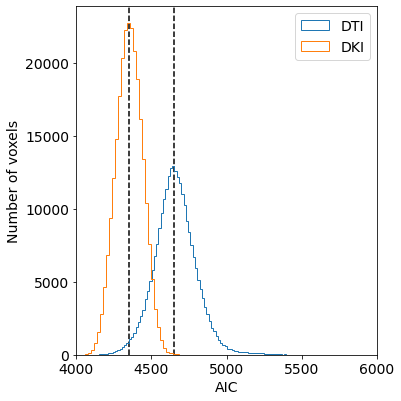

In [16]:
fig, ax = plt.subplots()
ax.hist(aic_dti[np.isfinite(aic_dti)], histtype='step', bins=100, label="DTI")
ax.hist(aic_dki[np.isfinite(aic_dki)], histtype='step', bins=50, label="DKI")
ax.set_xlim([4000, 6000])
ylims = ax.get_ylim()
ax.vlines(median_aic_dti[-1], *ylims, color='k', linestyle='--')
ax.vlines(median_aic_dki[-1], *ylims, color='k', linestyle='--')
ax.set_ylim(ylims)
ax.set_xlabel("AIC")
ax.set_ylabel("Number of voxels")
#ax.set_box_aspect(1)
#ax.text(0.07, 0.9, 'A', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=20)
plt.legend()
fig.set_size_inches([5.8, 5.8])
fig.set_tight_layout(True)
fig.savefig("single_subject_dist.png")


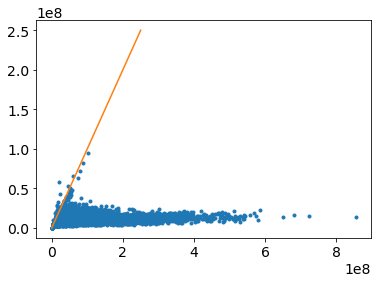

In [9]:
plt.plot(dti_sse_wm, dki_sse_wm, '.')
plt.plot([0, 2.5e8], [0, 2.5e8])

In [10]:
median_aic_dki

array([4267.69997527, 4273.39635461, 4273.17408026, ..., 4340.57376228,
       4186.06251634, 4351.38153667])

In [11]:
np.array(median_aic_dki) > np.array(median_aic_dti)

array([False, False, False, ..., False, False, False])

In [12]:
import seaborn as sns

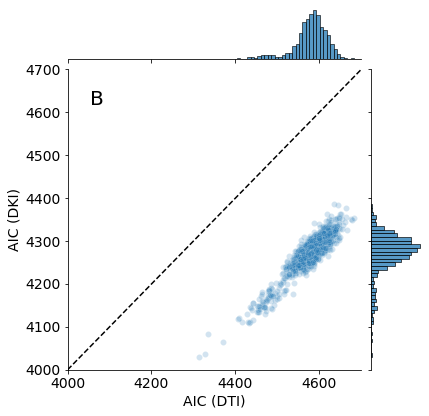

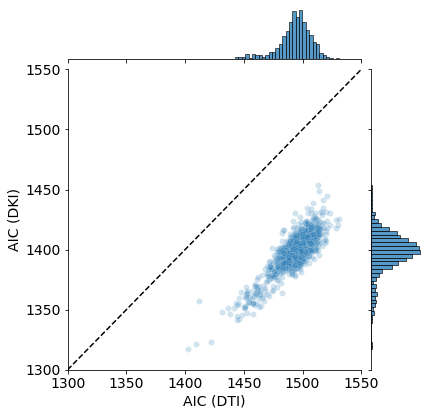

In [13]:
#fig, ax = plt.subplots(1,2)
pp = sns.jointplot(data=aic_df, x="aic_dti", y="aic_dki", alpha=0.2)
pp.ax_joint.set_xlabel("AIC (DTI)")
pp.ax_joint.set_ylabel("AIC (DKI)")
pp.ax_joint.set_xlim([4000, 4700])
pp.ax_joint.set_ylim([4000, 4700])
pp.ax_joint.plot([4000, 4700], [4000, 4700], 'k--')
pp.ax_joint.text(0.1, 0.9, 'B', horizontalalignment='center',verticalalignment='center', transform=pp.ax_joint.transAxes, fontsize=20)
pp.fig.savefig("hcp_dti_dki.png")

pp = sns.jointplot(data=aic_df, x="aic_dti1000", y="aic_dki1000", alpha=0.2)
pp.ax_joint.set_xlabel("AIC (DTI)")
pp.ax_joint.set_ylabel("AIC (DKI)")
pp.ax_joint.set_xlim([1300, 1550])
pp.ax_joint.set_ylim([1300, 1550])
pp.ax_joint.plot([1300, 1550], [1300, 1550], 'k--')
#pp.ax_joint.text(0.1, 0.9, 'C', horizontalalignment='center',verticalalignment='center', transform=pp.ax_joint.transAxes, fontsize=20)
pp.fig.savefig("hcp_dti_dki_1000.png")

In [14]:
# fig, ax = plt.subplots(1, 2)
# ax[0].scatter(median_aic_dti, median_aic_dki, alpha=0.1)
# ax[0].plot([2500, 3200], [2500, 3200], 'k--')
# ax[0].set_xlabel("AIC (DTI)", fontsize=14)
# ax[0].set_ylabel("AIC (DKI)", fontsize=14)
# ax[0].set_aspect("equal")
# ax[0].text(0.1, 0.9, 'A', horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
# ax[1].scatter(median_aic_dti1000, median_aic_dki1000, alpha=0.1)
# ax[1].plot([900, 1200], [900, 1200], 'k--')
# ax[1].set_xlabel("AIC (DTI)", fontsize=14)
# ax[1].set_aspect("equal")
# fig.set_tight_layout(True)
# fig.set_size_inches([8.25, 8.25])


In [15]:
!open .